In [1]:
import xlrd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
year_echantillon = [1958,1962,1967,1968,1973,1978,1981,1988,1993,1997,2002,2007,2012]

def set_data(tour):
    tab_data = []
    tab_elus_premier_tour = []
    

    #Transformer le taux de participation en un float utilisable

    def formatage_participation(dat):
        dat["Taux de participation (%)"] = dat["Taux de participation (%)"].str.replace(',','.')
        dat["Taux de participation (%)"] = dat["Taux de participation (%)"].str.slice(start = 0,stop = -1)
        dat["Taux de participation (%)"] = pd.to_numeric(dat["Taux de participation (%)"],downcast = 'signed')

    #En enregistrant un fichier (par erreur souvent) en .csv, on crée des problèmes qui peuvent être résolus ainsi

    def solve_problem_enregcsv(dat):
        def presolve(dat):    
            labels = list(dat.columns)
            dat = dat["Code département"].str.split(pat = ',',expand = True)
            dat[7] = dat[7].str.cat(dat[8], sep = ',')
            dat = dat.drop(8, axis = 1)
            dat.columns = labels
            return dat.replace('',0).fillna(0)
        dat = presolve(dat)
        for k in range(1,27):
            dat[str(k) + " voix"] = dat[str(k) + " voix"].astype(int)
        return dat

    #Dans certains fichiers, on observe plusieurs étiquettes de liste correspondant à la même nuance. Ici, on les fusionne.
    #Bien que cette hypothèse ne reflète pas les résultats finaux dans certains cas, ces doublons restent mineurs.
    #Cela revient à faire l'hypothèse d'unité de candidat par nuance.
    def merge_doublons_nuances(dat):
        labels = data.columns.values.tolist()
        todrop_or_nottodrop = False
        labels_todrop = []
        for k in range(len(labels) - 1):
            if labels[k] == labels[k+1] :
                todrop_or_nottodrop = True
                data[labels[k]] = data[labels[k]].sum(axis = 1)
                labels_todrop.append(k+1)
        for x in labels_todrop :
            labels[x] = "to drop"
        if todrop_or_nottodrop :
            dat.columns = labels
            return dat.drop(["to drop"], axis = 1)
        return dat
            
        
    for year in year_echantillon :
        data = pd.DataFrame(pd.read_csv("DATA_formatee\cdsp_legi"+str(year)+"t"+str(tour)+"_circ.csv"))

        #Type de données n°1
        if year < 1981 :
            if tour == 2 : 
                data = data.drop(['élu premier tour'],axis = 1)
            nuances = data.iloc[0].tolist()
            data = data.dropna()
            labels = data.columns.values.tolist()
            for k in range(len(labels)) :
                col = labels[k]
                if col not in ['Code département','département'] :
                    data[col] = data[col].astype(int)
                    if col not in ['circonscription','Inscrits','Votants','Exprimés','Blancs et nuls'] :
                        labels[k] = nuances[k]
            data.columns = labels
            data.insert(7,"Taux de participation (%)",100*data["Votants"] / data["Inscrits"])
            data = merge_doublons_nuances(data)
        
        #Type de données n°2    
        elif year != 1981 :
            labels = data.columns.values.tolist()
            u = labels[-1]
            while u[:2] == "Un" :
                labels.pop()
                data = data.drop([u],axis = 1)
                u = labels[-1]
            nb_candidats = int(u[:2])
            if year == 1993 : 
                data.insert(6,"Blancs et nuls",data["Votants"] - data["Exprimés"])
            data = data.fillna(0)
            for k in range(1,nb_candidats):
                data[str(k) + " voix"] = data[str(k) + " voix"].astype(int)
            formatage_participation(data)
            for col  in ['circonscription','Inscrits','Votants','Exprimés','Blancs et nuls'] :
                data[col] = data[col].astype(int)
            
        #Manque en 1981 la colonne de blancs et nuls    
        else : 
            if tour == 1 :
                data.insert(6,"Blancs et nuls",data["Votants"] - data["Exprimés"])
            data.insert(7,"Taux de participation (%)",100*data["Votants"] / data["Inscrits"])


        tab_data.append(data)
        print(str(year) + " : tour " + str(tour) + " initialisé")
        
    return tab_data    

data_t1 = set_data(1)
data_t2 = set_data(2)

data_global = [data_t1,data_t2]

1958 : tour 1 initialisé
1962 : tour 1 initialisé
1967 : tour 1 initialisé
1968 : tour 1 initialisé
1973 : tour 1 initialisé
1978 : tour 1 initialisé
1981 : tour 1 initialisé
1988 : tour 1 initialisé
1993 : tour 1 initialisé
1997 : tour 1 initialisé
2002 : tour 1 initialisé
2007 : tour 1 initialisé
2012 : tour 1 initialisé
1958 : tour 2 initialisé
1962 : tour 2 initialisé
1967 : tour 2 initialisé
1968 : tour 2 initialisé
1973 : tour 2 initialisé
1978 : tour 2 initialisé
1981 : tour 2 initialisé
1988 : tour 2 initialisé
1993 : tour 2 initialisé
1997 : tour 2 initialisé
2002 : tour 2 initialisé
2007 : tour 2 initialisé
2012 : tour 2 initialisé


In [2]:
def get_data(year,tour):
    if year not in year_echantillon : return "Pas d'élection sur cette année"
    else : return data_global[tour-1][year_echantillon.index(year)]

In [3]:
#Renvoie les résultats pour un tableur, du département et de sa circonscription indiqués

def get_line(data,num_dep,circo):
    
    if num_dep == "2A" :
        return data.loc[(data["département"] == 'CORSE-DU-SUD') & (data["circonscription"] == circo)]
    if num_dep == "2B" :
        return data.loc[(data["département"] == 'HAUTE-CORSE') & (data["circonscription"] == circo)]
    
    return data.loc[(pd.to_numeric(data["Code département"],errors = 'coerce') == num_dep) & (data["circonscription"] == circo)]
 

In [4]:
#Renvoie le score d'un parti donné, dans une année donnée, dans un département/circonscription donné/ée

def get_res(data,year,num_dep,circo,parti):
    ligne = get_line(data,num_dep,circo)
    
    if year < 1981 :
        colonnes_parti = [col for col in data.columns if parti in col]
        if (colonnes_parti != []) and (int(ligne[parti].values[0]) != 0) :
            return ligne[["département","circonscription","Votants",parti]]
        
    else:
        for k in range(1,23):
            val = (ligne[str(k) + " Etiquette liste"].values[0] == parti)
            if val :            
                return ligne[["département","Votants","circonscription","Taux de participation (%)",str(k) + " Accès second tour",str(k) + " voix"]]
    
    return "Pas de représentant du parti dans cette circonscription"


In [5]:
#Renvoie la liste des nuances présentées candidates au tour t d'une année donnée year

def cand(year,tour):
        data = get_data(year,tour)
        
        if year <= 1981 :
            L = data.columns[8:].tolist()

        else :
            L = []
            labels = data.columns.values.tolist()
            nb_candidats = int(labels[-1][:2])
            for k in range(1,nb_candidats+1):
                for i in range(data.index.size) :
                    nuance = data[str(k) + " nuance"].iloc[i]
                    if type(nuance) == str and nuance not in L : L.append(nuance)

        return list(OrderedDict.fromkeys(L))

In [6]:
#Renvoie la liste des nuances politiques représentées à chaque élection par année

from collections import OrderedDict

def liste_candidats_glob(year): return list(OrderedDict.fromkeys(cand(year,1)+cand(year,2)))

#Déclare une variable globale pour diminuer le coût en temps d'un accès

historique_candidats = [liste_candidats_glob(year) for year in year_echantillon]

In [7]:
def get_candidats(year): return historique_candidats[year_echantillon.index(year)]

In [213]:
#Renvoie la liste de toutes les nuances qui se sont déja présentées aux élections

def tous_candidats():
    L = []
    for year in year_echantillon : 
        L += get_candidats(year)
    return list(OrderedDict.fromkeys(L))

liste_candidats = tous_candidats()
candidats_tries = ['EXG','CEG','GAU','EXG','CEN','EXG','CEG','DRT','CED','CEG','CEN','DRT','CEN','EXD','EXD','GAU','EXG','DRT','DRT','CED','CEN','GAU','EXD','DRT','DRT','CEN','CEN','DRT','DRT','CED','DRT','DRT','DRT','DRT','EXG','EXG','GAU','EXG','GAU','CEN','CEN','DRT','CED','DRT','DRT','DRT','EXG','GAU','DRT','CED','DRT','DRT','DRT','EXD','EXG','GAU','GAU','EXG','GAU','EXG','CEN','CEN','GAU','EXD','GAU','GAU','DRT','DRT','GAU','EXG','GAU','GAU','DRT','EXG','CEG','DRT','CEN','CEN','GAU','CED','CEN','CEN','DRT']


In [214]:
#Objectif : avoir un seul type de données (pré/post - 1981) pour les exploiter plus facilement

def merge_datatype(year):
    data1,data2 = get_data(year,1),get_data(year,2)
    candidats = get_candidats(year)
    
    #Création de colonnes par nuance, puis remplissage avec le nombre de voix
    def merge(data):   
        ref = np.zeros((data.index.size,len(candidats)))
        df = pd.DataFrame(columns = candidats)
        max_cands = int(data.columns[-1][:2])
        
        for i in range(data.index.size):
            k = 1
            ligne = data.iloc[i]
            while  (k <= max_cands) and type(ligne.loc[str(k) + " nuance"]) == str :
                nuance = ligne.loc[str(k) + " nuance"]
                indice = candidats.index(nuance)
                ref[i,indice] += int(ligne.loc[str(k) + " voix"])
                k += 1
        
        for x in candidats :
            df[x] = ref[:,candidats.index(x)].astype(int)
        return pd.concat([data[["Code département","département","circonscription","Inscrits","Votants","Exprimés","Blancs et nuls","Taux de participation (%)"]],df],axis = 1)       
        
    return merge(data1),merge(data2)              


#Création d'un "nouveau" jeu de données cette fois plus uniforme

def new_dataset():
    L1,L2 = [],[]
    
    #Uniformisation de la liste des nuances entre tour 1 et 2 (ce qui n'est pas toujours le cas selon les années ex:1968)
    def unite_candidats(data,year):
        for x in get_candidats(year):
            if x not in data.columns : data[x] = 0
        return data
    
    for year in year_echantillon :
        if year <= 1981 :
            L1.append(unite_candidats(get_data(year,1),year))
            L2.append(unite_candidats(get_data(year,2),year))
        else :
            new1,new2 = merge_datatype(year)
            L1.append(unite_candidats(new1,year))
            L2.append(unite_candidats(new2,year))
        print(str(year) + " initialisé")
    return [L1,L2]

new_data = new_dataset()

1958 initialisé
1962 initialisé
1967 initialisé
1968 initialisé
1973 initialisé
1978 initialisé
1981 initialisé
1988 initialisé
1993 initialisé
1997 initialisé
2002 initialisé
2007 initialisé
2012 initialisé


In [215]:
def new_getdata(year,tour):
    if year not in year_echantillon : return "Pas d'élection sur cette année"
    else : return new_data[tour-1][year_echantillon.index(year)]

In [216]:
liste_nuances = ["EXG","GAU","CEG","CEN","CED","DRT","EXD"] 

def merge_nuances():
    data_merged = [[],[]]
    
    def merge(data):
        df = data.copy()
        L = list(data.columns)[8:]
        for x in L:
            pos = candidats_tries[liste_candidats.index(x)]
            df = df.rename(columns = {x : pos})
        for pos_spec in liste_nuances :
            if pos_spec not in df.columns :
                df[pos_spec] = 0
        df = df.groupby(df.columns, axis = 1).sum()
        df = df[["département","Code département","circonscription","Inscrits","Votants","Exprimés","Blancs et nuls","Taux de participation (%)","EXG","GAU","CEG","CEN","CED","DRT","EXD"]]
        return df
    
    for k in range(26):
        data_merged[k//13].append(merge(new_data[k//13][k%13]))
    
    return data_merged
                    
data_uni = merge_nuances()

In [217]:
def getdata_unif(year,tour):
    if year not in year_echantillon : return "Pas d'élection sur cette année"
    else : return data_uni[tour-1][year_echantillon.index(year)]

In [218]:
#Renvoie le tableau des vainqueurs au scrutin majoritaire pour un tour et une année donnée

def tab_maxvotes(year,tour):
    data = new_getdata(year,tour)
    
    winners = data.drop(['Inscrits','département','Votants','Exprimés','Blancs et nuls'], axis = 1).idxmax(axis = 1, numeric_only = True)
    votes = data.drop(['Inscrits','département','Votants','Exprimés','Blancs et nuls'], axis = 1).max(axis = 1, numeric_only = True)
        
    res = pd.concat([data['département'],data['circonscription'],winners.rename('Nuance/Parti vainqueur'),votes.rename('Nombre de voix'),(100 * votes/data['Exprimés']).rename('Part de voix (%)'),(100 * data['Votants']/data['Inscrits']).rename("Taux de participation (%)")], axis = 1)
    
    if year == 1968 and tour == 2 : res["Nuance/Parti vainqueur"] = res["Nuance/Parti vainqueur"].replace("UDR-RI","RIUDR")
    
    return res

In [219]:
#Renvoie les indices de circonscriptions où le candidat a été élu au premier tour
def get_elus1er():
    
    res = []
    for year in year_echantillon :
        tab = tab_maxvotes(year,1)
        res.append([i for i in range(tab.index.size) if tab["Part de voix (%)"].iloc[i] >= 50])
            
    return res
            
elus1er_indices = get_elus1er()

In [221]:
#Renvoie le résultat d'un scrutin majoritaire (1 tour / 2 tours avec sélection des deux meilleurs + élus premiers tours)
def res_majoritaire(year,tour):
    data = getdata_unif(year,tour)
    tab = tab_maxvotes(year,1)
    candidats = get_candidats(year)
    res = pd.Series(0,index = liste_nuances)
    
    if tour == 1 : temp = tab["Nuance/Parti vainqueur"].value_counts().reindex(candidats,fill_value = 0)                                                                       
                                                                               
    else :   
        
        #Ajoute les élus au 1er tour dans le cas d'un scrutin à deux tours
        def add_winners_1ertour(tab2):
            loc = tab2["Nuance/Parti vainqueur"].value_counts()
            indices = elus1er_indices[year_echantillon.index(year)]
            for i in indices :
                winner = tab["Nuance/Parti vainqueur"].iloc[i]
                if winner not in loc.index : 
                    win_series = pd.Series({winner : 1})
                    loc = pd.concat([loc,win_series], names = [tab2.index.tolist(),winner])
                else : loc[winner] += 1
            return loc
        
        temp = add_winners_1ertour(tab_maxvotes(year,2)).reindex(candidats,fill_value = 0)
    
    #Rajoute le score de chaque parti au positionnement politique lui correspondant
    for k in temp.index :
        pos = candidats_tries[liste_candidats.index(k)]
        res[pos] += temp[k]
        
    return res

res_majoritaire(1978,2)

EXG     86
GAU    112
CEG      0
CEN      0
CED      0
DRT    283
EXD      0
dtype: int64

In [222]:
def res_proportionnelle_dep(year,taux,seuil):
    data = getdata_unif(year,1).copy()
    sieges_dep = pd.DataFrame(data["Code département"].value_counts()).sort_index(ascending = True)
    data = data.groupby(["Code département"]).sum(numeric_only = True).drop(["circonscription","Taux de participation (%)"],axis = 1)
    winners = data.drop(['Inscrits','Votants','Exprimés','Blancs et nuls'], axis = 1).idxmax(axis = 1, numeric_only = True)
    
    #Selectionne les nuances ayant obtenu plus de seuil% de voix au premier tour
    def selec_seuillards(x):
        for i in range(data.index.size) :
            min_votes = x * data["Exprimés"].iloc[i]
            for nuance in data.columns.tolist()[4:] :
                if data[nuance].iloc[i] < min_votes : 
                    data[nuance].iloc[i] = 0
    selec_seuillards(seuil)
    
    sieges_prop = np.floor(sieges_dep*taux)
    res = pd.Series({'Nuance/Parti vainqueur' : np.zeros(1)}).reindex(liste_nuances,fill_value = 0)
    
    #Répartition des sièges associés à la proportionnelle entre les candidats sélectionnés aupravant
    def split_sieges_dep(code_dep):
        i = sieges_prop.index.values.tolist().index(code_dep)
        nb_sieges = sieges_prop.iloc[i].values[0]
        sieges_prop.iloc[i] = 0
        line = data.iloc[i]
        for x in liste_nuances :
            #Discuter de l'arrondi à l'entier le plus proche
            sieges_attribues = round(nb_sieges*(line[x]/line["Exprimés"]))
            res.loc[x] += sieges_attribues
            sieges_prop.iloc[i] += sieges_attribues
    
    #Ajoute les sièges des vainqueurs majoritaires
    #Discuter de la méthode de répartition des sièges restants
    def add_winners(code_dep):
        i = sieges_prop.index.values.tolist().index(code_dep)
        nb_sieges = sieges_dep.iloc[i].values[0] - sieges_prop.iloc[i].values[0]
        winner = winners.iloc[i]
        res.loc[winner] += nb_sieges
    
    for code_dep in sieges_prop.index :          
        split_sieges_dep(code_dep)
        add_winners(code_dep)
    
    return res

In [223]:
def res_proportionnelle_nation(year,taux,seuil):
    data = getdata_unif(year,1).copy()
    sieges_tot = len(data.index.tolist())
    data = data.sum(numeric_only = True).drop(["circonscription","Taux de participation (%)"])
    winner = data.drop(['Inscrits','Votants','Exprimés','Blancs et nuls']).idxmax()
    
    #Selectionne les nuances ayant obtenu plus de seuil% de voix au premier tour
    def selec_seuillards(x):
        min_votes = x * data.loc["Exprimés"]
        for nuance in data.index.tolist()[4:] :
            if data.loc[nuance] < min_votes : 
                data.loc[nuance] = 0
    selec_seuillards(seuil)
    
    sieges_prop = np.floor(sieges_tot*taux)
    res = pd.Series({'Nuance/Parti vainqueur' : np.zeros(1)}).reindex(liste_nuances,fill_value = 0)
    
    #Répartition des sièges associés à la proportionnelle entre les candidats sélectionnés aupravant
    def split_sieges():
        for x in liste_nuances :
            sieges_attribues = np.floor(sieges_prop*(data.loc[x]/data.loc["Exprimés"]))
            res.loc[x] += sieges_attribues
    
    #Ajoute les sièges du vainqueur majoritaire
    #Refaire l'attribution à l'échelle départementale
    def add_winners():
        res.loc[winner] += sieges_tot - res.sum()
             
    split_sieges()
    add_winners()
    
    return res

In [225]:
#Diverses fonctions de comparaison de modes de scrutin, utilisables par repartition_barh à la cellule suivante

#Comparaison manuelle
def compare(year,taux_prop,seuil_prop):

    candidats = liste_candidats
    res_t1 = res_majoritaire(year,1)
    res_t2 = res_majoritaire(year,2)
    res_prop_dep = res_proportionnelle_dep(year,taux_prop,seuil_prop)
    res_prop_nation = res_proportionnelle_nation(year,taux_prop,seuil_prop)
    
    results = {
        str(year) + ' : Scrutin majoritaire à un tour': res_t1.values.tolist(),
        str(year) + ' : Scrutin majoritaire à deux tours' : res_t2.values.tolist(),
        str(year) + ' : Scrutin proportionnel départemental à seuil ' + str(100*seuil_prop) + '%' + ' et à taux ' + str(100*taux_prop) + '%' : res_prop_dep.values.tolist(),
        str(year) + ' : Scrutin proportionnel national à seuil ' + str(100*seuil_prop) + '%' + ' et à taux ' + str(100*taux_prop) + '%' : res_prop_nation.values.tolist()
    }
    
    return results,candidats

#Étudie l'influence du taux de proportionnelle pour une année et un seuil donnés, à l'échelle départementale
def prop_dep_selon_taux(year,seuil_prop):    
    candidats = liste_nuances
    prop_taux = [(str(year) + ' : Scrutin proportionnel départemental à seuil ' + str(100*seuil_prop) + '%' + ' et à taux ' + str(100*taux_prop) + '%' , res_proportionnelle_dep(year,taux_prop,seuil_prop) ) for taux_prop in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]]
    results = dict(prop_taux)
    return results,candidats

#Étudie l'influence du taux de proportionnelle pour une année et un seuil donnés, à l'échelle nationale
def prop_nation_selon_taux(year,seuil_prop):    
    candidats = liste_nuances
    prop_taux = [(str(year) + ' : Scrutin proportionnel national à seuil ' + str(100*seuil_prop) + '%' + ' et à taux ' + str(100*taux_prop) + '%' , res_proportionnelle_nation(year,taux_prop,seuil_prop) ) for taux_prop in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]]
    results = dict(prop_taux)
    return results,candidats

#Affiche l'historique de composition avec un scrutin majoritaire à deux tours

#À corriger (unite )
def maj2tours_selon_year():
    candidats = liste_nuances
    L = [(str(year) + ' : Scrutin majoritaire à deux tours', res_majoritaire(year,2)) for year in year_echantillon]
    results = dict(L)
    return results,candidats

(<Figure size 1584x288 with 1 Axes>, <AxesSubplot:>)

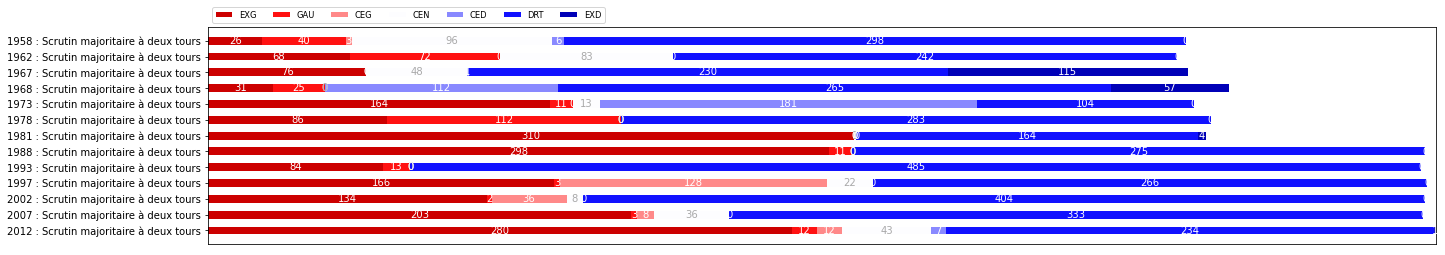

In [226]:
#Affiche la répartition de l'Assemblée Nationale par nuance politique pour les différents modèles sélectionnés
# N.B : de légères variations dans le nombre total de sièges peuvent apparaître du fait d'erreurs de données
def repartition_barh(results, category_names):
    
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['seismic_r'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(22, 4))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
    
    #SET COLORMAP / UNIFIER NUANCES
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax

results,candidats = maj2tours_selon_year()
repartition_barh(results,candidats)

In [20]:
def mean_var(res_set):
    res_matrix = np.array(list(res_set.values()))
    nb_candidats = res_matrix.shape[1]
    L_mean,var = [],0
    for i in range(nb_candidats):
        col = res_matrix[:,i]
        L_mean.append(col.mean())
        var += col.var()
    res = L_mean,np.sqrt(var)/sum(res_matrix[0])
    return res[1]

mean_var(results)

0.4863644511388909

Text(0.5, 1.0, "Évolution de l'influence du taux de proportionnelle selon le seuil")

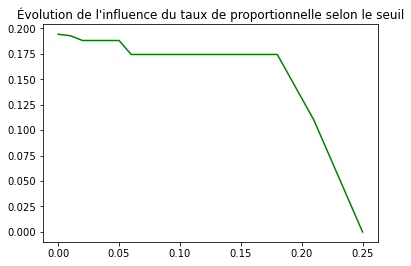

In [21]:
#CELLULE TEST
X_sample = [0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,.12,.15,.18,.21,.25]
result_list = [mean_var(prop_nation_selon_taux(1973,seuil)[0]) for seuil in X_sample]
plt.plot(X_sample,result_list,color = 'g')
plt.title("Évolution de l'influence du taux de proportionnelle selon le seuil")

#Question du graphique inverse ?

In [212]:
liste_candidats.index("DVD")
#candidats_tries[51]

33